In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import sparse

import plotly.graph_objects as go
from sklearn.manifold import TSNE
from textblob import Word
from nltk.corpus import stopwords
import nltk
import re
from pprint import pprint
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')

%matplotlib inline

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package wordnet to /home/ag16115/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## functions

In [3]:
def pc_scores(X, r):
    U, s, Vh = sparse.linalg.svds(X,k=r)
    idx = s.argsort()[::-1]   
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    return Y

In [4]:
def clean_text(text):
    return " ".join([ Word(word).lemmatize() for word in re.sub("[^A-Za-z0-9]+", " ", text).lower().split() if word not in stopword])  

In [5]:
def del_email_address(text):
    e = '\S*@\S*\s?'
    pattern = re.compile(e)
    return pattern.sub('', text) 

## data sort

In [6]:
newsgroups = fetch_20newsgroups()
pprint(list(newsgroups.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [7]:
## create dataframe from newsgroup data
df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(lambda row: newsgroups["target_names"][row])

In [10]:
## list of common words to delete
stopword = set(nltk.corpus.stopwords.words("english"))
stopword.update(['subject'])

In [11]:
## gets rid of email addresses  in data
df["data_str"] = df.data.apply(lambda row: del_email_address(row))
# gets rid of stopwords, symbols, makes lower case and base words
df["data_str"] = df.data_str.apply(lambda row: clean_text(row))

In [14]:
## use random sample of data
s_df = df.sample(n=7500, replace=False, random_state=22).reset_index(drop=True)

## pc scores

In [15]:
## vectorize
vectorizer = TfidfVectorizer()
Y = vectorizer.fit_transform(s_df.data_str)

In [16]:
(n,p) = Y.shape
print(n,p)

7500 75879


In [17]:
## pca to 3 dimensions
zeta = pc_scores(p**-.5 * Y,3)

In [18]:
zeta_df = pd.DataFrame(zeta)
zeta_df["target"] = np.array(s_df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)

In [19]:
## pca to 20 dimensions, t-sne to 2 dimensions
zeta1 = pc_scores(p**-.5 * Y,20)
tsne_zeta = TSNE(n_components=2,perplexity = 30).fit_transform(zeta1)

/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ag16115/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(s_df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

In [21]:
target_colour = {'alt.atheism' : 'goldenrod',
 'comp.graphics' : 'steelblue',
 'comp.os.ms-windows.misc': 'skyblue',
 'comp.sys.ibm.pc.hardware' : 'lightblue',
 'comp.sys.mac.hardware' : 'powderblue',
 'comp.windows.x' : 'deepskyblue',
 'misc.forsale' : 'maroon',
 'rec.autos' : 'limegreen',
 'rec.motorcycles' : 'green',
 'rec.sport.baseball' : 'yellowgreen',
 'rec.sport.hockey' : 'olivedrab',
 'sci.crypt' : 'pink',
 'sci.electronics' : 'plum',
 'sci.med' : 'orchid',
 'sci.space' : 'palevioletred',
 'soc.religion.christian' : 'darkgoldenrod', 
 'talk.politics.guns' : 'coral',
 'talk.politics.mideast' : 'tomato',
 'talk.politics.misc' : 'darksalmon',
 'talk.religion.misc' : 'gold'}

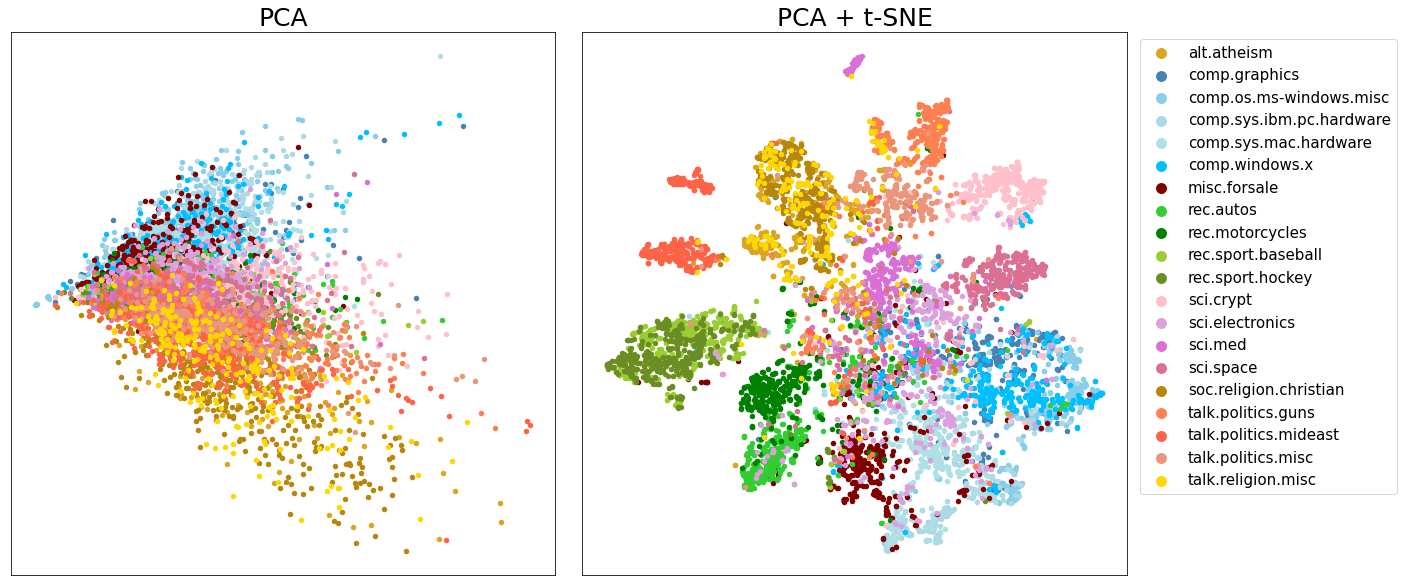

In [22]:
## plot figure 2

fig,ax = plt.subplots(1,2,figsize = (20,10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0],t_df[1], marker = 'o',edgecolor='black', linewidth=0,s = 30,label = t,c= target_colour[t]);
ax[0].set_title(f'PCA',fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0],t_df[1], marker = 'o',edgecolor='black', linewidth=0,s = 30,label = t, alpha = 1,c= target_colour[t]);
ax[1].set_title(f'PCA + t-SNE',fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(1.51, 1) ,prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

#fig.savefig(f"newsgroup.pdf", bbox_inches='tight')